**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

***Content***
1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Launch, monitor, and maintain your system.


# 0. Setup Python

First, let's import a few common modules and ensure MatplotLib plots figures inline. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥ 1.0.1.

In [1]:
# Python ≥3.11 is required
import sys
#assert sys.version_info >= (3, 11)

# Scikit-Learn ≥ 1.6 is required
from packaging import version
import sklearn
print(sklearn.__version__)
#assert version.parse(sklearn.__version__) >= version.parse("1.6")

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt


1.5.0


# 1. Look at the Big Picture
- We will build a model of housing prices per district in California
- Input: population, median income, median housing price for each block group
- Block group (aka district): smallest geographical unit for which the US Census Bureau publishes sample
data (a block group typically has a population of 600 to 3,000 people)

# Frame the problem
- Ask what the business objective is!
- This determines 
    - which algorithms to select
    - which performance measure you will use
    - how much effort you will spend tweaking it

Example of Bigger Picture:
![](img/pipeline.png)
In this case, the results will be used to determine whether it is worth investing in a given area or not. Getting this
right is critical, as it directly affects revenue.



Before you continue, ask yourself: 
- What are the instances? 
- Which techniques to use? 
    - reinforcement learning?
    - (un)supervised learning? 
    - classification/regression? 
    - batch/online learning? 




Answers: 
- instances = districts
- techniques
    - supervised learning: housing price = label
    - regression: predicting a number
    - multiple regression: multiple input features
    - univariate regression: predicting single value per district
    - batch learning: no continuous flow of new data

# Select a performance measure
## Root Mean Square Error (RMSE)
This is the preferred measure for most regression problems. 


![](img/rmse.png)
![](img/rmse-notations-1.png)
![](img/rmse-notations-2.png)

## Mean Absolute Error (MAE)
In some contexts you may prefer MAE over RMSE. For example if there are many outlier districts because RMSE penalizes larger errors (due to the square). 

![](img/mae.png)

Remark that both RMSE and MAE are expressed in the same unit as the y values and as such they can be compared and their values can easily be interpreted. 

## Mean Absolute Percentage Error (MAPE)
The mean absolute percentage error (MAPE), is another measure of prediction accuracy of a forecasting method in statistics. It measures the average magnitude of error produced by a model, or how far off predictions are on average. A MAPE value of 20% means that the average absolute percentage difference between the predictions and the actuals is 20%.

It usually expresses the accuracy as a ratio defined by the formula:

$$
\text{MAPE}(\mathbf{X}, h) = \frac{1}{m} \sum_{i=1}^{m} \frac{\left| h\left(\mathbf{x}^{(i)}\right) - y^{(i)} \right|}{y^(i)}
$$

Remark that both RMSE and MAE are expressed in the same unit as the y values and as such they can be compared and their values can easily be interpreted. 

#### Exercise 

- Calculate the mean absolute error, root mean squared error and mean absolute percentage error for the model we created for the spring temperatures in Brussels. The metrics `mean_absolute_error`,  `mean_squared_error` and `mean_absolute_percentage_error` are available from the scikit-learn module `sklearn.metrics`.  
- Interprete the results. 

# 2. Get the Data

## Download the Data

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

## Take a Quick Look at the Data Structure

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.tail(10 )

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20630,-121.32,39.29,11.0,2640.0,505.0,1257.0,445.0,3.5673,112000.0,INLAND
20631,-121.40,39.33,15.0,2655.0,493.0,1200.0,432.0,3.5179,107200.0,INLAND
20632,-121.45,39.26,15.0,2319.0,416.0,1047.0,385.0,3.1250,115600.0,INLAND
20633,-121.53,39.19,27.0,2080.0,412.0,1082.0,382.0,2.5495,98300.0,INLAND
20634,-121.56,39.27,28.0,2332.0,395.0,1041.0,344.0,3.7125,116800.0,INLAND
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Observations: 
- 20640 districts in the dataset
- total_bedrooms is missing for 207 districts --> take care of this later
- All attributes are numerical, except the ocean_proximity field, which is _object_
object
- We see that it is categorical: 

In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

The describe() method shows a summary of
the numerical attributes

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


#### Plot a histogram for each numerical attribute

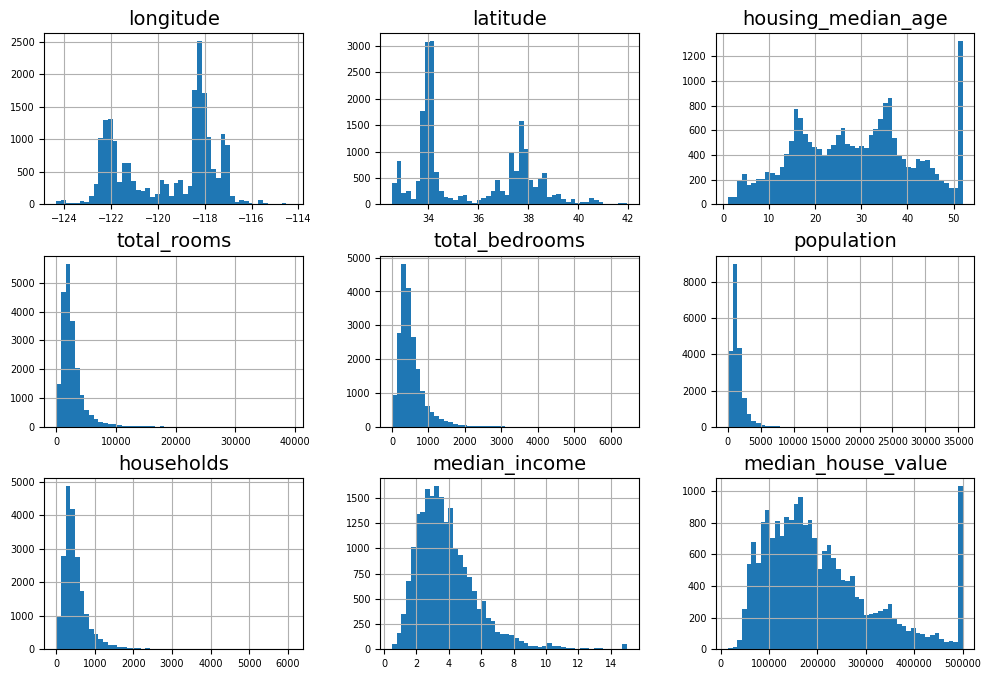

In [8]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

housing.hist(bins=50, figsize=(12, 8))
plt.show()

Observations: 
1. Median (yearly) income is not expressed in US dollars.  After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly
tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine
Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.  
2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target
attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your
client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions
even beyond $500,000, then you have two options:
    - Collect proper labels for the districts whose labels were capped.
    - Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond  500,000).
3. These attributes have very different scales. We will discuss this later in this chapter, when we explore feature scaling.
4. Finally, many histograms are tail-heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder
for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped
distributions.

## Create a Test Set

__WARNING__

Wait! Before you look at the data any further, you need to create a test set, put it aside,
and never look at it.

In [9]:
# to make this notebook's output identical at every run
import numpy as np
np.random.seed(42)

If you don't use _np.random.seed(42)_ and you run the program again, it will generate a different test set! Over time, you (or your Machine Learning
algorithms) will get to see the whole dataset, which is what you want to avoid.

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is _train_test_split()_

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [11]:
len(train_set)

16512

In [12]:
len(test_set)

4128

In [13]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120,65600.0,INLAND
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308,353400.0,<1H OCEAN
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925,466700.0,NEAR OCEAN
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,500001.0,<1H OCEAN
9814,-118.44,34.18,33.0,2127.0,414.0,1056.0,391.0,4.3750,286100.0,<1H OCEAN


- Random sampling is fine if your dataset is large enough (relative to the number of attributes)
- But you run the risk of introducing a significant sampling bias
- Suppose the median income is a very important attribute to predict median housing prices.
- Then make sure that you have +/- the same distribution in your test set as in the whole dataset. 
- This is called __stratified sampling__ which is especially useful if you a have skew dataset. 
- Since the median income is a continuous numerical attribute, you first need to create an income category attribute.

In [14]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [15]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


In [16]:
housing["income_cat"].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: >

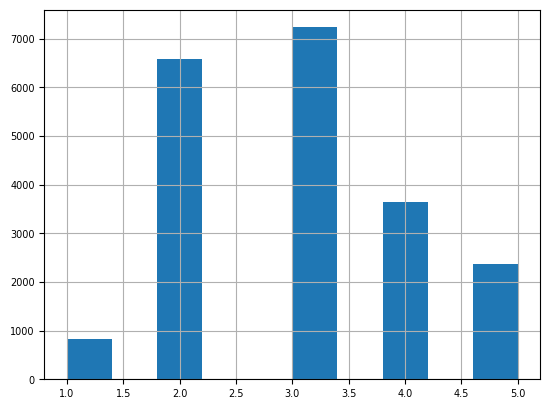

In [17]:
housing["income_cat"].hist()

See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [18]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

Let's check if this worked: are income category proportions in test set equal to complete dataset? 

In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [20]:
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

Yes!

Now we can remove _income_cat_. 

In [21]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 3. Discover and Visualize the Data to Gain Insights

From now on, we work exclusively with the training set. 

In [22]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

<Axes: xlabel='longitude', ylabel='latitude'>

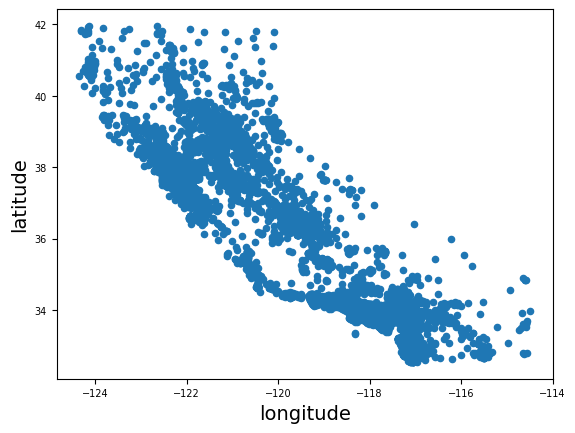

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Setting the alpha option to 0.2 makes it much easier to visualize the places where there is a high density of data points

<Axes: xlabel='longitude', ylabel='latitude'>

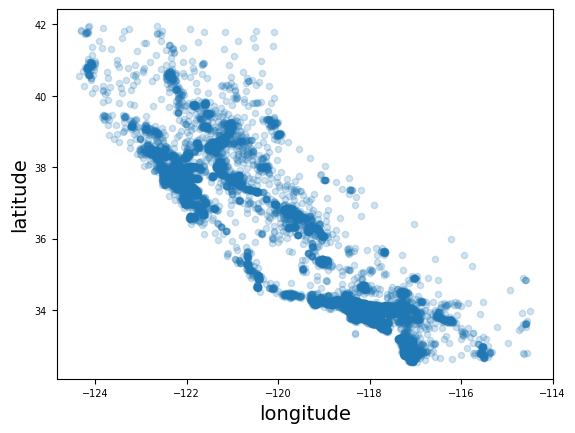

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)

Now let’s look at the housing prices. The radius of each circle represents the district’s population (option s), and the color represents the
price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices). 

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). Thanks to Wilmer Arellano for pointing it out.

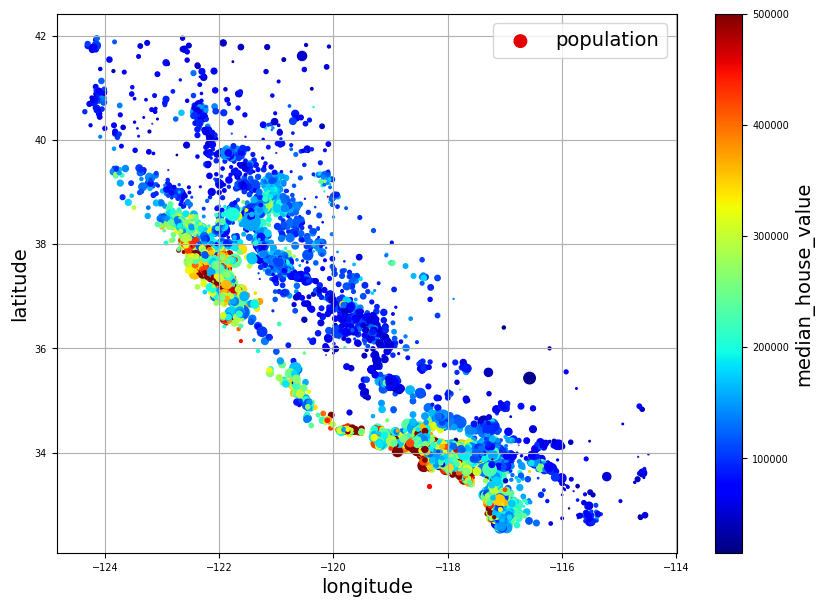

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

#### START NICE TO KNOW

In [26]:
# Download the California image
images_path = os.path.join(".", "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x209e622cda0>)

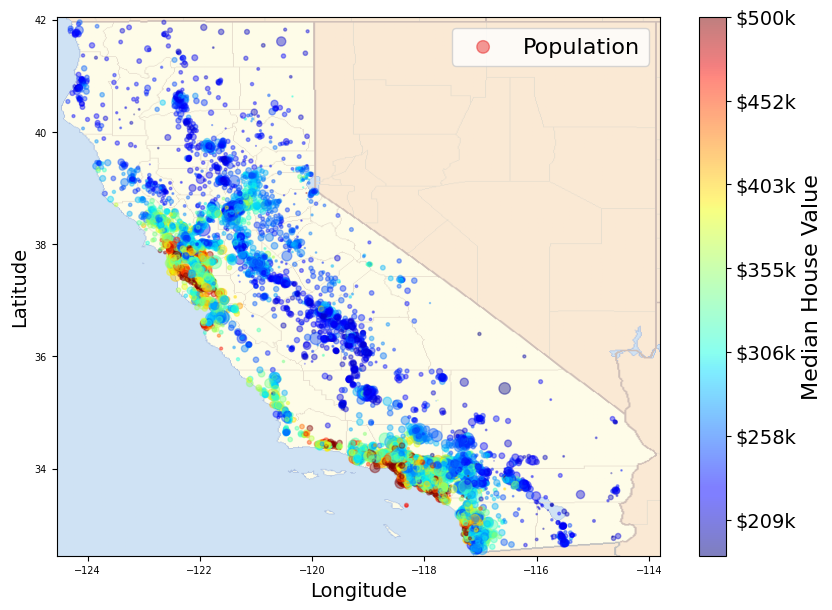

In [27]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

#### END NICE TO KNOW

## Looking for Correlations

Compute the standard correlation coefficient (also called Pearson’s r) between every pair of numeric attributes:

In [28]:
corr_matrix = housing.corr(numeric_only=True)

In [29]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


In [30]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

- Another way to check for correlation between attributes is to use the Pandas `scatter_matrix()` function, which plots every numerical attribute against every other numerical attribute. 
- Since there are now 11 numerical attributes, you would get 112 = 121 plots, which would not fit on a page—so you decide to focus on a few promising attributes that seem most correlated with the median housing value

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

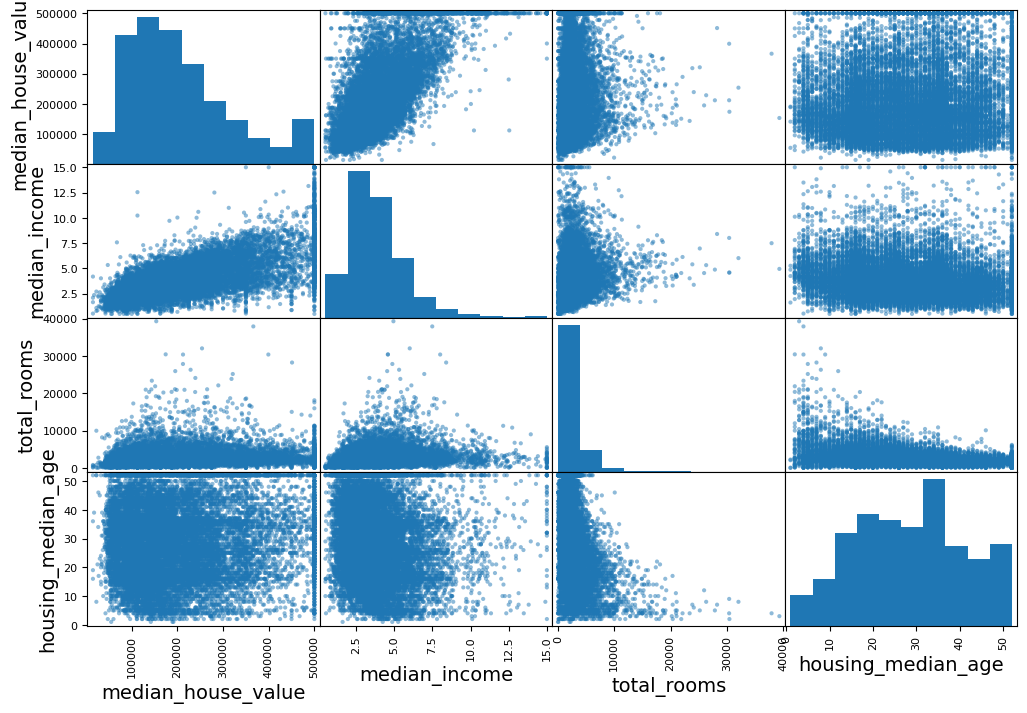

In [31]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

On the diagonal a histogram of the attribute is plotted. 

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot.

(0.0, 16.0, 0.0, 550000.0)

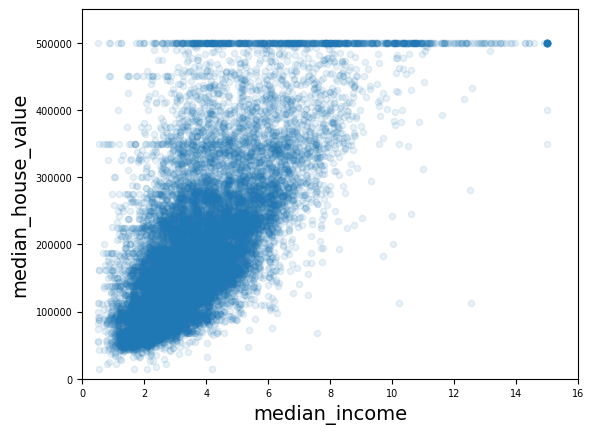

In [32]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

Observations:
1. The correlation is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed. 
2. The price cap that we noticed earlier is clearly visible as a horizontal line at $500,000. 
3. Less obvious straight lines: 
    - a horizontal line around $450,000
    - another around $350,000
    - perhaps one around $280,000
    - a few more below that. 
    
You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

## Experimenting with Attribute Combinations

- The total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms
per household. 
- Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. 
- And the population per household also seems like an interesting attribute combination to look at. 

Let’s create these new attributes:


In [33]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [34]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms.

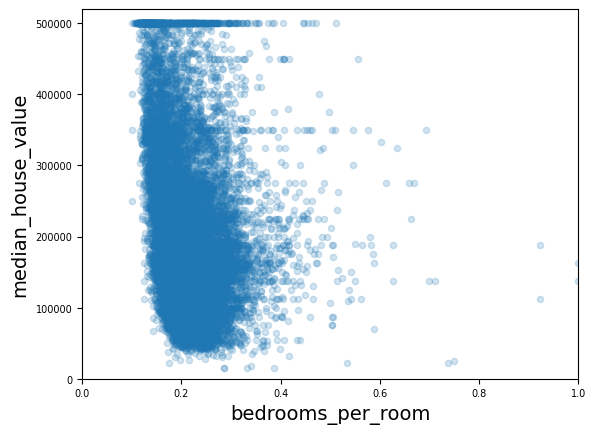

In [35]:
housing.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value",
             alpha=0.2)
plt.axis([0, 1, 0, 520000])
plt.show()

In [36]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000
mean,-119.573125,35.637746,28.577156,2639.402798,538.949094,1425.513929,499.990189,3.870428,206333.518653,5.441010,0.212796,2.995974
std,2.000624,2.133294,12.585738,2185.287466,423.862079,1094.795467,382.865787,1.891936,115314.047529,2.574143,0.057417,4.457373
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.888889,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.000000,296.000000,787.000000,279.000000,2.562500,119200.000000,4.443636,0.175257,2.433426
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1167.000000,408.000000,3.538500,179200.000000,5.235573,0.203106,2.822316
75%,-118.010000,37.720000,37.000000,3154.000000,645.000000,1726.000000,603.000000,4.750000,263925.000000,6.053843,0.239421,3.286385
max,-114.490000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,502.461538


Data exploration is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

# 4. Prepare the Data for Machine Learning Algorithms

Let's revert to the original training set and separate the target (note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`):

In [37]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. We saw earlier that the
total_bedrooms attribute has some missing values, so let’s fix this. You have three options:

```python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

To demonstrate each of them, let's create a copy of the housing dataset, but keeping only the rows that contain at least one null. Then it will be easier to visualize exactly what each option does:

In [38]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [39]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [40]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [41]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

C:\Users\loicv\AppData\Local\Temp\ipykernel_32464\760120979.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3


In [42]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


We decide to choose option 3 and use the sklearn class SimpleImputer

In [43]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [44]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [45]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [46]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Check that this is the same as manually computing the median of each attribute:

In [47]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Now you can use this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [48]:
X = imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. If you want to put it back into a pandas DataFrame, it’s simple:

In [49]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,index=housing_num.index)

In [50]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


## Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [51]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


Most Machine Learning algorithms prefer to work with numbers, so let’s convert these categories from text to numbers.

In [52]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [53]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One **issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values**. This may be fine in
some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obviously not the case for the ocean_proximity column
(for example, categories 0 and 4 are clearly more similar than categories 0 and 1).

A common **solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise)**, and so on. The new attributes are sometimes called dummy attributes.  

This is called **One Hot Encoding**. 

In [54]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of
categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up
tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. You can use it
mostly like a normal 2D array, but if you really want to convert it to a (dense) NumPy array, just call the toarray() method:

In [55]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

Alternatively, you can set `spars_output=False` when creating the `OneHotEncoder`:

In [56]:
cat_encoder = OneHotEncoder(sparse_output=False)  # by default OneHotEncoder returns a sparse matrix, sckit-learn >= 1.4: sparse_output=False, < 1.4: sparse=False
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [57]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Pandas has a function called `get_dummies()`, which also converts each categorical
feature into a one-hot representation, with one binary feature per category:

In [58]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


It looks nice and simple, so why not use it instead of `OneHotEncoder`? Well, the
advantage of `OneHotEncoder` is that it remembers which categories it was trained
on. This is very important because once your model is in production, it should be
fed exactly the same features as during training: no more, no less. Look what our
trained `cat_encoder` (that has been trained on a dataset with 5 different categories) outputs when we make it transform the same `df_test` (using
`transform()`, not `fit_transform()`):

In [59]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

See the difference? `get_dummies()` saw only two categories, so it outputs two columns,
whereas `OneHotEncoder` outpus one column per learned category, in the right order.
Moreover, if you feed `get_dummies()` a DataFrame containing an unknown category
(e.g., "<2H OCEAN"), it will happily generate a column for it:

Kan zeker een examenvraag zijn!!!

In [60]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


But `OneHotEncoder` is smarter: it will detect the unknown category and raise
an exception. If you prefer, you can set the `handle_unknown hyperparameter` to
"ignore", in which case it will just represent the unknown category with zeros:

In [61]:

cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [62]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [63]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

You can also convert the result of the one-hot-encoding in a dataframe:

In [64]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

**Remark**: create your one hot encoder with `OneHotEncoder(sparse_output=False)` is you want to convert your transformed (one-hot encoded) numpy arry into a pandas dataframe. 

In [65]:
df_test_unknown

,ocean_proximity
0,<2H OCEAN
1,ISLAND


In [66]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


**Important**: when using your model in production on new data you have to execute exactly the same transformations on the new data as you did on the training data before training the model. But if your new data has fewer (or more) categories than your training data you will get other features, so your model is no longer applicable. 

## Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. 

This is the case for the housing data: 
- the total number of rooms ranges from about 6 to 39.320
-  the median incomes only range from 0 to 15. 

Note that scaling the target values is generally not required. There are two common ways to get all attributes to have the same scale: 

- min-max scaling
- standardization.

__Min-max scaling__ (aka __normalization__)
- simplest scaler
- values are shifted and rescaled so that they end up ranging from 0 to 1. 
- subtract the min value and divide by the max minus the min. 
- Scikit-Learn provides a transformer called `MinMaxScaler` for this. 

__Standardization__ 
- first it subtracts the mean value (so standardized values always have a zero mean)
- then it divides by the standard deviation so that the resulting distribution has unit variance. 
- Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). 
- Standardization is much less affected by outliers. 
- For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–
15 down to 0–0.15, whereas standardization would not be much affected.

__WARNING__

As with all the transformations, it is important to _fit the scalers to the training data only, not to the full dataset_ (including the test set)only: never use `fit()` or `fit_transform()` for anything
else than the training set. Only then can you use them to transform the training set and the test set (and new data).

In [67]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [68]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

When a feature’s distribution has a heavy tail (i.e., when values far from the mean
are not exponentially rare), both min-max scaling and standardization will squash
most values into a small range. Machine learning models generally don’t like this
at all, as you will see in Chapter 4. So before you scale the feature, you should first
transform it to shrink the heavy tail, and if possible to make the distribution roughly
symmetrical. For example, a common way to do this for positive features with a heavy
tail to the right is to replace the feature with its square root (or raise the feature to
a power between 0 and 1). If the feature has a really long and heavy tail, then replacing the feature with its logarithm may help. The  figure below shows how much better this feature looks
when you compute its log: it’s very close to a Gaussian distribution (i.e., bell-shaped).

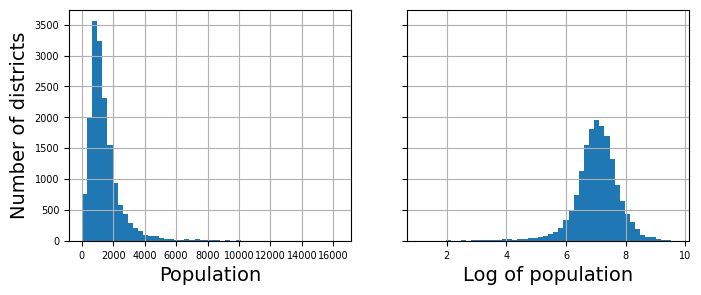

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

## Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes.   
  
For transformations that don’t require any training, you can just write a function
that takes a `NumPy` array as input and outputs the transformed array. For example,
as discussed in the previous section, it’s often a good idea to transform features
with heavy-tailed distributions by replacing them with their logarithm (assuming the
feature is positive and the tail is on the right). Let’s create a log-transformer and apply
it to the population feature:

In [70]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log)
log_pop = log_transformer.transform(housing[["population"]])

## Transformation Pipelines
Scikit-Learn provides the `Pipeline` class to help with sequences of transformations.

In [71]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

- If you don’t want to name the transformers, you can use the `make_pipeline()` function instead.
- It takes transformers as positional arguments and creates a `Pipeline` using the names of the transformers’ classes, in lowercase and without underscores (e.g., "simpleimputer"):

In [72]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

When you call the pipeline’s `fit()` method, it calls `fit_transform()` sequentially on
all the transformers, passing the output of each call as the parameter to the next call
until it reaches the final estimator, for which it just calls the `fit()` method.

In [73]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

- Now also add the categorical attribute(s). 
- It would be more convenient to have a single transformer capable of handling all columns, applying the appropriate transformations to each column. 
- For this, you can use a `ColumnTransformer`. 
- For example, the following `ColumnTransformer` will apply 
  - `num_pipeline` (the one we just defined) to the numerical attributes and 
  - `cat_pipeline` to the categorical attribute:

In [74]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),  # missing categorical values are filled with most frequent values
    OneHotEncoder(handle_unknown="ignore"))  

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

- Since listing all the column names is not very convenient, Scikit-Learn provides a `make_column_selector()` function that returns a selector function you can use to automatically select all the features of a given type, such as numerical or categorical.
- You can pass this selector function to the `ColumnTransformer` instead of column names or indices. 
- Moreover, if you don’t care about naming the transformers, you can use `make_column_transformer()`, which chooses the names for you, just like `make_pipeline()` does. 
- For example, the following code creates the same `ColumnTransformer` as earlier, except the transformers are automatically named "pipeline-1" and "pipeline-2" instead of "num" and "cat":

In [75]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

Now we’re ready to apply this `ColumnTransformer` to the housing data:

In [76]:
housing_prepared = preprocessing.fit_transform(housing)

In [77]:
housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

We're almost ready to start training some models! We'll now create a single pipeline that will perform the following transformations: 

- Missing values in numerical features will be imputed by replacing them with
the median, as most ML algorithms don’t expect missing values. 
- In categorical features, missing values will be replaced by the most frequent category.
- The categorical feature will be one-hot encoded, as most ML algorithms only
accept numerical inputs.
- A few ratio features will be computed and added: bedrooms_ratio,
rooms_per_house, and people_per_house. Hopefully these will better correlate
with the median house value, and thereby help the ML models.
- Features with a long tail will be replaced by their logarithm, as most models
prefer features with roughly uniform or Gaussian distributions.
- All numerical features will be standardized, as most ML algorithms prefer when
all features have roughly the same scale.  
  
The code that builds the pipeline to do all of this should look familiar to you by now:

In [78]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log),
    StandardScaler())

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

If you run this `ColumnTransformer`, it performs all the transformations and outputs a
`NumPy` array with 16 features:

In [79]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 16)

# 5. Select and Train a Model

Now we are ready to select and train a machine learning model. Start with a very basis model: linear regression. 

## Training and Evaluating on the Training Set

In [80]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())  
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function column_ratio at 0x00000209E66D7B...
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000209E8C668D0>)])),
                ('linearregression', LinearRegression())])

Let's try the full preprocessing pipeline on a few training instances:

In [97]:
housing_predictions = lin_reg.predict(housing) # here the advantage of creating a pipeline becomes clear. 
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([260100., 357900., 125800., 110000., 298900.])

Compare against the actual values:

In [98]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

Well, it works, but not always: the first prediction is way off, while the other predictions are better. Remember that we chose to use the RMSE as our performance measure, so we want to measure this regression model’s RMSE on the whole training
set using Scikit-Learn’s `root_mean_squared_error()` function:

RMSE on training set: 

In [99]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)

lin_rmse

70630.22169174395

This is better than nothing, but clearly not a great score: the median_housing_values of most districts range between $120.000 and $265.000, so a typical prediction error of $70.634 is really not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean 
- that the features do not provide enough information to make good predictions, or 
- that the model is not powerful enough. 
 
As we saw in the previous chapter, the main ways to fix underfitting are 
- to select a more powerful model
- to feed the training algorithm with better features, or 
- to reduce the constraints on the model. 

This model is not regularized, which rules out the last option. You could try to add more features, but first you want to try a more complex model to see how it does.

Let's traing another model: `DecisionTreeRegressor`, a powerful model, capable of finding complex nonlinear relationships in the data. 

Decision Trees are handled in detail in Chapter 6. 

In [100]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function column_ratio at 0x000002B95FD7A2...
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002B964077A10>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [101]:
housing_predictions = tree_reg.predict(housing)
from sklearn.metrics import root_mean_squared_error
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)

tree_rmse

0.0

No error --> probably the model has badly overfit the data. As we have seen earlier, we need to use part of the training set for training and part of it for model validation.

## Better Evaluation Using Cross-Validation

See slides and book Chapter 1. 

The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times,
picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [102]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [103]:
tree_rmses

array([67897.27353908, 67197.30283212, 67277.24709122, 71966.27626017,
       68779.0570529 , 71028.92564167, 71323.51926886, 73874.61088177,
       71074.25742475, 70011.29853473])

WARNING

Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the RMSE (i.e., a negative value), which is why the preceding code computes -score.

In [104]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     70042.976853
std       2211.223510
min      67197.302832
25%      68117.719418
50%      70520.112088
75%      71261.203808
max      73874.610882
dtype: float64

Now the decision tree doesn’t look as good as it did earlier. In fact, it seems to perform almost as poorly as the linear regression model! Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). 

The decision tree has an RMSE of about 70.043, with a standard deviation of about 2.211. You would not have this information if you just used one validation set. 

But cross-validation comes at the cost of training the model several times, so it is not always feasible.

Let's do the same for the Linear Regression

In [105]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     71790.679774
std       3986.780025
min      68141.823309
25%      69635.918807
50%      70743.145126
75%      72002.873114
max      82334.167571
dtype: float64

Let’s try one last model now: the RandomForestRegressor. As we will see in Chapter 7, Random Forests work by training many Decision Trees on random
subsets of the features, then averaging out their predictions. Building a model on top of many other models is called _Ensemble Learning_, and it is often a
great way to push ML algorithms even further.

In [106]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [107]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     49632.089212
std       1020.064249
min      47620.869586
25%      49099.175089
50%      49749.949265
75%      50183.743922
max      51263.448191
dtype: float64

Wow, this is much better: random forests really look very promising for this task!  

However, if you train a RandomForest and measure the RMSE on the training set (see below), you will find roughly 18.469: that’s much lower, meaning that there’s still quite a lot of overfitting going on. Possible solutions are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.

Before you dive much deeper into random forests, however, you should try out many other models from various categories of machine learning algorithms (e.g., several support vector machines with different kernels, and possibly a neural network), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising
models.

In [108]:
# Let's check the RMSE on the training set. 
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)
forest_rmse

18469.486046590784

# 6. Fine-Tune Your Model

We now have a shortlist of promising models and will now need to fine-tune them.

## Grid Search

All you need to do is tell the class `GridSearchCV` which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values. Don't worry about the meaning of the hyperparameters for now. 

In [109]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    # try 9 (3×3) combinations of hyperparameters with bootstrap set as True (default)
    {'random_forest__n_estimators': [3, 10, 30], 'random_forest__max_features': [4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'random_forest__bootstrap': [False], 'random_forest__n_estimators': [3, 10], 'random_forest__max_features': [2, 3, 4]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(func=<function column...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002B964077A10>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'random_forest__max_features': [4, 6, 8],
                          'random_forest__n_estimators': [3, 10, 30]},
                         {'random_forest__bootstrap': [False],
                          'random_forest__max_features': [2, 3, 4],
                          'random_forest__n_estimators': [3, 10]}],
             scoring='neg_root_mean_squared_error')

The best hyperparameter combination found:

In [110]:
grid_search.best_params_

{'random_forest__max_features': 6, 'random_forest__n_estimators': 30}

In [111]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function column_ratio at 0x000002B95FD7A200>)...
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002B964193320>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, n_estimators=30,
                                       random_state=42))])

Let's look at the score of each hyperparameter combination tested during the grid search:

In [112]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

59673.242059748845 {'random_forest__max_features': 4, 'random_forest__n_estimators': 3}
52868.851345360534 {'random_forest__max_features': 4, 'random_forest__n_estimators': 10}
50740.976370901735 {'random_forest__max_features': 4, 'random_forest__n_estimators': 30}
59195.94873368102 {'random_forest__max_features': 6, 'random_forest__n_estimators': 3}
52383.00414832617 {'random_forest__max_features': 6, 'random_forest__n_estimators': 10}
50506.779898920795 {'random_forest__max_features': 6, 'random_forest__n_estimators': 30}
60066.584625792566 {'random_forest__max_features': 8, 'random_forest__n_estimators': 3}
53342.81004514595 {'random_forest__max_features': 8, 'random_forest__n_estimators': 10}
50742.72562177273 {'random_forest__max_features': 8, 'random_forest__n_estimators': 30}
62433.055482550415 {'random_forest__bootstrap': False, 'random_forest__max_features': 2, 'random_forest__n_estimators': 3}
54428.51161977491 {'random_forest__bootstrap': False, 'random_forest__max_features'

## Evaluate Your System on the Test Set

We have set apart our test set before starting any modeling. No, at the very end, we can use it to evaluate the performance of the chosen model. 

In [113]:
final_model= grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)  # the same transformations will be executed on the test set!

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

49438.1095374696


In [115]:
from sklearn.metrics import root_mean_squared_error

final_predictions_test = lin_reg.predict(X_test)
lin_rmse_test = root_mean_squared_error(y_test, final_predictions_test)

lin_rmse_test

76862.27404904473

# 7. Launch, monitor, and maintain your system.

## Model persistence using joblib

We can now deploy our model to a production environment.  

The most basic way to do this is just to save the best model we trained, transfer the file to our production environment, and load it.

In [116]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

Now we can deploy this model to production. For example, the following code could be a script that would run in production:

In [117]:
import joblib

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

Important remark: the final model also contains all preprocessing (data preparation and cleaning). 

In [119]:
predictions

array([411676.7       , 477136.8       , 100193.33333333,  97896.66666667,
       363653.36666667])

Now you can use `final_model_loaded` in a production system to estimate house prices for new districts or new district data.   

In general you train and fine tune your model in a Python notebook (.ipynb file) and you use the deployed model in a Python application (.py file)